In [1]:
from openhsi.calibrate import SettingsBuilderMixin, SettingsBuilderMetaclass
from openhsi.cameras import IDSCamera
import os
from openhsi.data import crop
import glob
import json

# using Metaclasses
SettingsBuilder = SettingsBuilderMetaclass("SettingsBuilder",IDSCamera,{})

top_folder = os.path.join(os.getcwd(), '..', '..')

settings_file = top_folder +'/configs/cam_settings_ids.json'

# initialising
sb = SettingsBuilder(json_path=settings_file)



with open(settings_file, 'r') as f:
        settings = json.load(f)

#calibration = {:}
# using Metaclasses
#sb = SettingsBuilderMixin()


#sb.settings = settings
#sb.fit_HgAr_lines()

IDSCameraBase __init__
{'json_path': 'c:\\Users\\haavasl\\VsCodeProjects\\uw-openhsi\\uw-openhsi\\ids\\..\\../configs/cam_settings_ids.json'}
Allocated 16.31 MB of RAM. There was 13427.70 MB available.
Found-Device-Callback: Key=C:\Program Files\IDS\ids_peak\ids_ueyegentl\64\ids_ueyegentl.cti|IDS GenICam Producer (uEye)|IDS uEye Interface|IDS/UI306xCP-M/4103870701-0
Using Device IDS UI306xCP-M (IDS/UI306xCP-M/4103870701-0)
The default clock frequency is 474000000.0
The maximized frequency is 474000000.0
The maximal frame rate is 343.52456200618343 for pixelformat Mono8
7372.919 mu seconds exposure time


In [2]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_spectral_cal_images(image_fn_list:list, is_12bit:bool = True, is_10bit:bool = False):
    """_summary_

    :param image_fn: _description_
    :type image_fn: list
    :param is_12bit: _description_, defaults to True
    :type is_12bit: bool, optional
    :param is_10bit: _description_, defaults to False
    :type is_10bit: bool, optional
    """
    gain = 1
    
    if is_10bit:
        gain = 2**6 # 64
        is_raw_16bit_uint = True
    if is_12bit:
        gain = 2**4 # 16
        is_raw_16bit_uint = True
    else:
        is_raw_16bit_uint = False

    image0 = cv2.imread(image_fn_list[0], cv2.IMREAD_UNCHANGED)

    count_img = np.zeros(image0.shape)
    avg_img = np.zeros(image0.shape)

    # Difine saturations
    if is_raw_16bit_uint:
        sat_val = 2**16 - 1
    else:
        sat_val = 2**8 - 1


    for image_path in image_fn_list:
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

        
        # Define row mask:
        row_image_max = np.max(image, axis = 1) # One per spatial pixel coord
        row_mask = row_image_max != sat_val # 
        
        avg_img[row_mask, :] += image[row_mask,:]/gain # Add 
        count_img[row_mask, :] += image[row_mask,:]*0 + 1 # Wierd way of only adding images counts where unmasked 


    
    # At the end, to avoid invalid division
    avg_img[count_img!=0] /= count_img[count_img!=0]
    

    return avg_img, count_img





calibration_image_folder = os.path.join(os.getcwd(), '..', '..', 'calibration_data')

dark_image_folder = calibration_image_folder+'/Dark'
spectral_image_folder = calibration_image_folder+'/Spectral'
radiometric_image_folder = calibration_image_folder +'/Radiometric'

spectral_image_filenames_Ar = glob.glob(os.path.join(spectral_image_folder, 'argon*'))
spectral_image_filenames_Hg = glob.glob(os.path.join(spectral_image_folder, 'mercury*'))

radiometric_image_filenames = glob.glob(os.path.join(radiometric_image_folder, 'e200*'))
dark_image_filenames = glob.glob(os.path.join(dark_image_folder, '*2000ms*'))

avg_dark, _ = extract_spectral_cal_images(dark_image_filenames)
avg_radiometric, _ = extract_spectral_cal_images(radiometric_image_filenames)
avg_img_Hg, _ = extract_spectral_cal_images(spectral_image_filenames_Hg)
avg_img_Ar, _ = extract_spectral_cal_images(spectral_image_filenames_Ar)



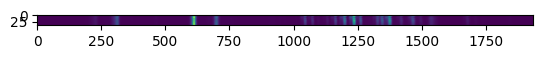

In [3]:
"""sb.settings['row_slice'] = [row_start, row_end]
def crop(self, x):
    return x[settings["row_slice"][0]:settings["row_slice"][1],:]

spectra = avg_img_Ar
"""
HgAr_pic = avg_img_Ar+avg_img_Hg

row_start = 610
row_end = 650

sb.settings['row_slice'] = [row_start, row_end]
sb.calibration = {'HgAr_pic': HgAr_pic}
plt.imshow(HgAr_pic[row_start:row_end])



sb.update_smile_shifts()

sb.calibration['smile_shifts'] = sb.calibration['smile_shifts']*0
#sb.fit_HgAr_lines()

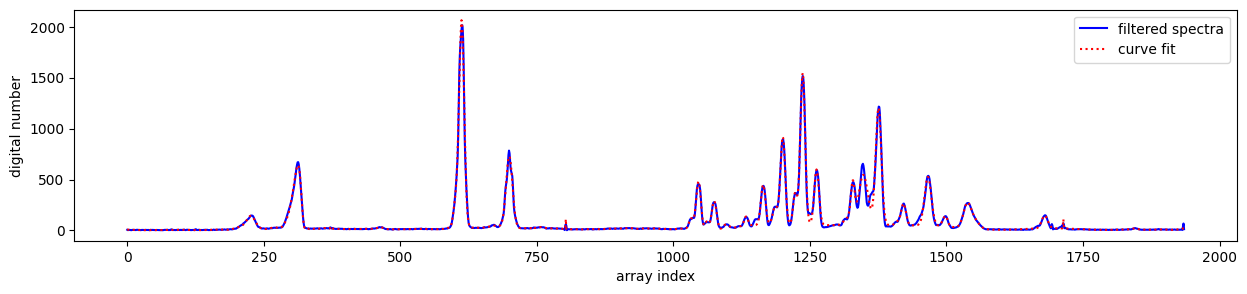

Predicted λ [340.53549302 380.35667582 393.32775605 396.93562233 407.41410491
 415.99529049 426.18645008 439.34805722 441.2411792  458.74972851
 446.17729525 448.16269911 450.19841983 445.11036455 490.86689069
 465.02443833 502.38254287 540.40383379 521.93681698 529.23807344
 536.78689766 543.50542637 565.08345156 574.19452057 585.8192975
 590.1084888  594.55601173 574.54133463 606.45767588 610.68015996
 614.10720488 620.98859896 625.89255063 632.22689004 635.37409091
 640.04338416 645.09686404 641.20207457 657.64469718 662.28786986
 666.1939396  672.3160745  679.1526553  704.43725133 691.63702562
 696.48333263 701.70492135 706.43588082 713.01701253 722.19690578
 727.1132564  738.17945981 745.89910109 750.85108021 758.80114165
 763.71415909 772.68384724 785.5863515  792.326362   796.03687972
 802.8674142  812.68275654 824.74750051 828.84143603 844.62051864
 854.44025233 856.36139851 869.8469655  874.16077032 890.23596226
 920.0201457  924.65366832 932.06485524 960.08282781 974.95130719

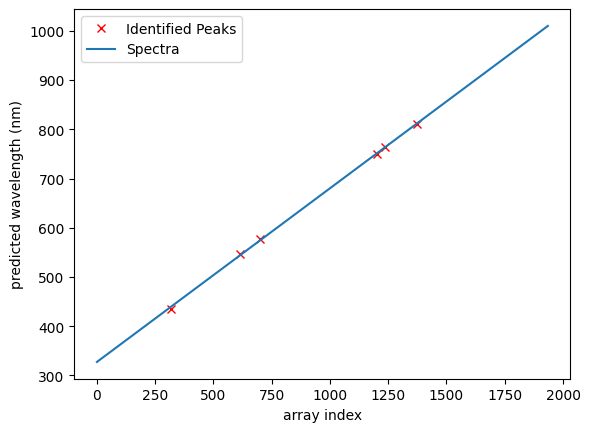

difference HgAr_lines - λ = 64.12050698447797
difference HgAr_lines - λ = 24.29932417717282
difference HgAr_lines - λ = 11.32824394809603
difference HgAr_lines - λ = 7.720377674338522
difference HgAr_lines - λ = 0.36889508635920265
difference HgAr_lines - λ = 8.212290492287707
difference HgAr_lines - λ = 9.646549919210258
difference HgAr_lines - λ = 3.515057216109085
difference HgAr_lines - λ = 5.40817920093366
difference HgAr_lines - λ = 22.916728510537553
difference HgAr_lines - λ = 10.34429525130571
difference HgAr_lines - λ = 12.329699108343618
difference HgAr_lines - λ = 14.3654198275363
difference HgAr_lines - λ = 9.277364549375989
difference HgAr_lines - λ = 55.03389069452089
difference HgAr_lines - λ = 29.191438331191705
difference HgAr_lines - λ = 43.69145712656257
difference HgAr_lines - λ = 5.670166205489068
difference HgAr_lines - λ = 24.137183015770574
difference HgAr_lines - λ = 16.835926557281596
difference HgAr_lines - λ = 9.28710233620211
difference HgAr_lines - λ = 2.

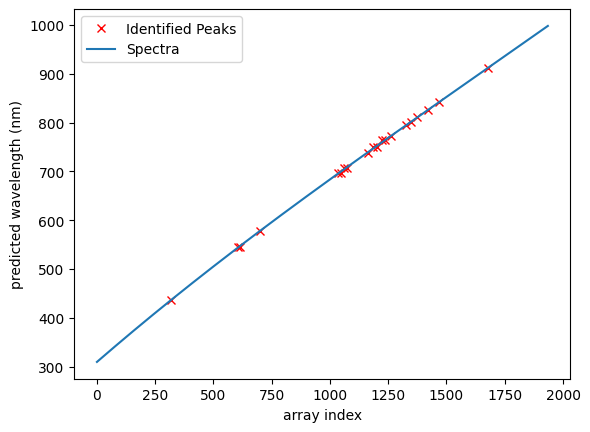

:Overlay
   .Curve.I     :Curve   [x]   (y)
   .Curve.II    :Curve   [x]   (y)
   .Curve.III   :Curve   [x]   (y)
   .Curve.IV    :Curve   [x]   (y)
   .Curve.V     :Curve   [x]   (y)
   .Curve.VI    :Curve   [x]   (y)
   .Curve.VII   :Curve   [x]   (y)
   .Curve.VIII  :Curve   [x]   (y)
   .Curve.IX    :Curve   [x]   (y)
   .Curve.X     :Curve   [x]   (y)
   .Curve.XI    :Curve   [x]   (y)
   .Curve.XII   :Curve   [x]   (y)
   .Curve.XIII  :Curve   [x]   (y)
   .Curve.XIV   :Curve   [x]   (y)
   .Curve.XV    :Curve   [x]   (y)
   .Curve.XVI   :Curve   [x]   (y)
   .Curve.XVII  :Curve   [x]   (y)
   .Curve.XVIII :Curve   [x]   (y)
   .Curve.XIX   :Curve   [x]   (y)
   .Curve.XX    :Curve   [x]   (y)
   .Curve.XXI   :Curve   [x]   (y)

In [4]:

# The default "brightest peaks would lead to erroneous calibration". Values are taken from the HgAr_lines list in openhsi/calibration.py
# For some unknown reason, the optimization takes a while (3 minutes ish)
sb.fit_HgAr_lines(filter_window=5, brightest_peaks = [546.074,763.511, 811.531, 750.387, 576.960, 435.833], max_match_error=10, top_k=20, verbose=True)

In [5]:
HgAr_lines = np.array([404.656,407.783,435.833,546.074,576.960,579.066,696.543,706.722,727.294,738.393,
                           750.387,763.511,772.376,794.818,800.616,811.531,826.452,842.465,912.297])

HgAr_lines.shape

(19,)

KeyError: 'sigma'

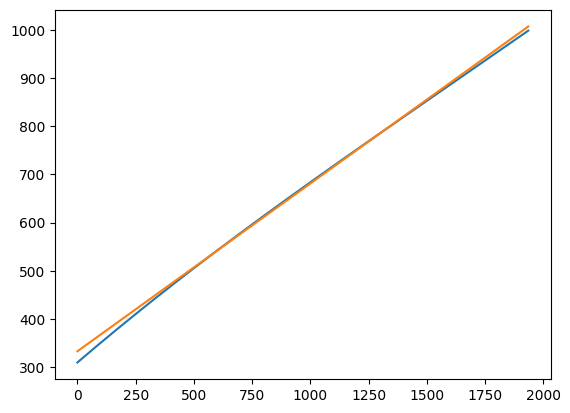

In [6]:
# The proposed calibration 
plt.plot(np.arange(HgAr_pic.shape[1]), sb.calibration['wavelengths'])
plt.plot(np.arange(HgAr_pic.shape[1]), sb.calibration['wavelengths_linear'])


sigma_pix = sb.calibration['sigma']

fwhm_pix = sigma_pix*2.3548

pixel_stepsize = (sb.calibration['wavelengths_linear'].max() - sb.calibration['wavelengths_linear'].min())/sb.calibration['wavelengths_linear'].size

fwhm_nm = np.percentile(pixel_stepsize*fwhm_pix, 50)

print(np.percentile(pixel_stepsize*fwhm_pix/2.3548, 50))

settings['fwhm_nm'] = fwhm_nm

In [9]:

wlens = sb.calibration['wavelengths']
print(wlens)

HgArInds = np.zeros(HgAr_lines.shape)
for i in range(HgAr_lines.size):
    HgArInds[i] = np.argmin(np.abs(HgAr_lines[i] - wlens))

[309.6990451  310.11277942 310.52641328 ... 997.5487162  997.88585362
 998.22301231]


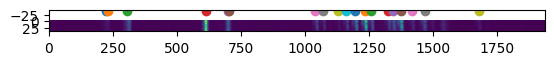

In [18]:
plt.imshow(HgAr_pic[row_start:row_end])

for ind in HgArInds:
    plt.scatter(np.array([ind]), np.array([-(row_end-row_start)]) )


In [10]:
# Defining the AOI horizontally (spectrally)
max_wl = 800
min_wl = 400
start_col = np.argmin(np.abs(min_wl-wlens))
stop_col = np.argmin(np.abs(max_wl-wlens))

print(start_col)
print(stop_col)

settings['win_offset'][0] = start_col
settings['win_resolution'][0] = stop_col - start_col

# 

224
1342


In [1]:
# Find the 

avg_radiometric
image = cv2.imread(r"C:\Users\haavasl\VsCodeProjects\uw-openhsi\calibration_data\Radiometric\e250_2.png", cv2.IMREAD_UNCHANGED)

#min_max_spatial = (286:824)
plt.imshow(image[:,:]/16)
plt.colorbar()
plt.clim([0, 4095])
plt.figure()

plt.imshow(avg_dark[:,:stop_col])

plt.figure()
plt.plot(image[:,1000]/16)

plt.plot([286, 286], [0, 4095], c = 'k')
plt.plot([824, 824], [0, 4095], c = 'k')
plt.ylim([0, 4095])

NameError: name 'avg_radiometric' is not defined

In [ ]:
with open(self.json_path[:-5]+"_updated.json" if json_path is None else json_path, 'w') as outfile:
            json.dump(self.settings, outfile,indent=4,)
with open(self.pkl_path[:-4]+"_updated.pkl" if pkl_path is None else pkl_path,'wb') as handle:
    pickle.dump(self.calibration,handle,protocol=4)